In [2]:
from Plain import Dissertation_Plain_1D

In [8]:
if __name__ == "__main__":
    model = Dissertation_Plain_1D(
        D=1.0, rho=1.0, K=1.0,
        k=1.0,            # λ
        n0=1.0,           # initial tumour density
        m0=0.5,           # initial ECM density
        Mmax=1.0, perc=0.2,
        L=1000.0, N=5001,
        T=800.0, dt=0.1,
        scheme="AB2AM2",
        init_type="tanh",
        steepness=0.1
    )

    model.solve()

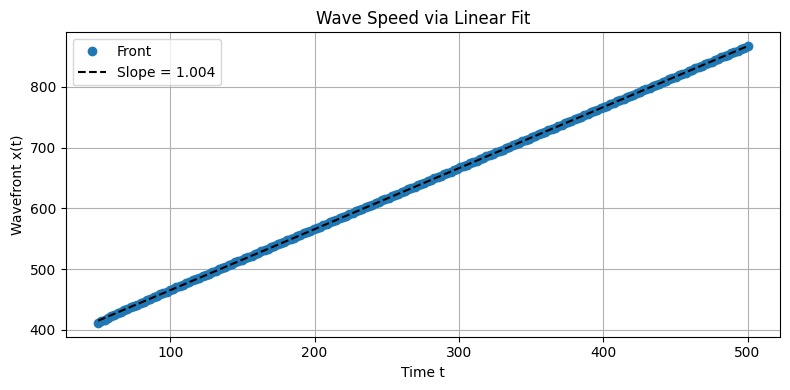

Estimated speed = 1.0039, R² = 1.0000


(np.float64(1.0038866757993523),
 np.float64(365.15089594625465),
 np.float64(0.9999787706828304))

In [9]:
model.estimate_wave_speed()

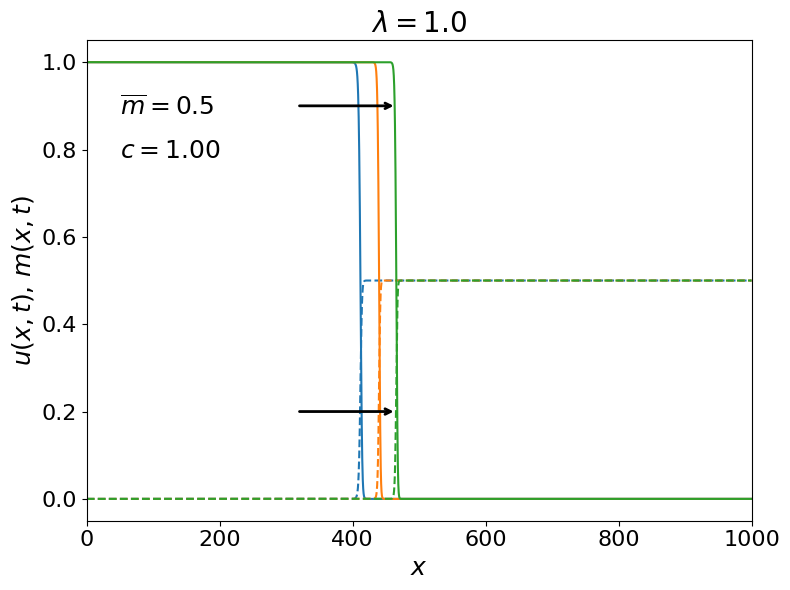

In [39]:
model.plot_u_m_with_custom_style([500, 750, 1000])

In [40]:
model1 = Dissertation_Plain_1D(
    D=1.0, rho=1.0, K=1.0,
k=1.0,            # λ
n0=1.0,           # initial tumour density
m0=0.5,           # initial ECM density
Mmax=1.0, perc=0.2,
L=200.0, N=1001,
T=200.0, dt=0.1,
scheme="AB2AM2",
init_type="tanh",
steepness=0.1)

model1.solve()

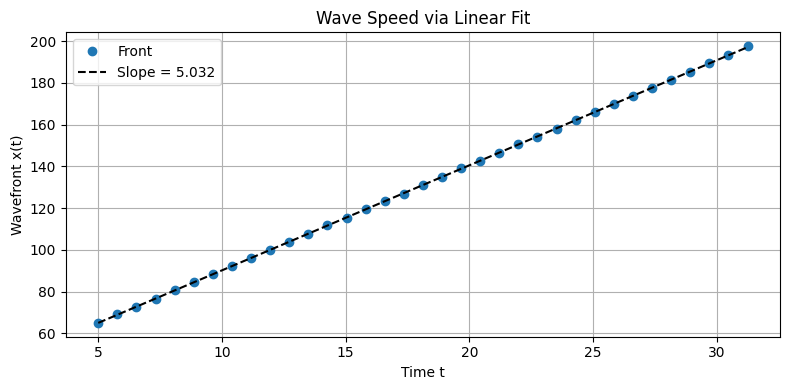

Estimated speed = 5.0323, R² = 1.0000


(np.float64(5.032309761732283),
 np.float64(39.90294202133104),
 np.float64(0.9999817392731435))

In [44]:
model1.estimate_wave_speed(t_start=5, t_end=120, num_points=150)

❌ Not enough valid front points.


TypeError: unsupported format string passed to NoneType.__format__

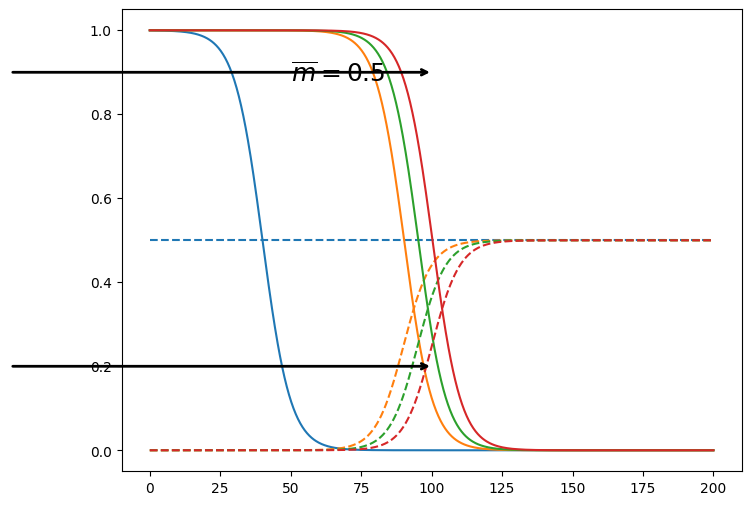

In [43]:
model1.plot_u_m_with_custom_style([0, 100, 110, 120])

In [53]:
import numpy as np
from scipy.sparse import eye, diags
from scipy.sparse.linalg import spsolve
from scipy.interpolate import CubicSpline, PchipInterpolator, Akima1DInterpolator, interp1d
from scipy.optimize import root_scalar
from scipy.stats import linregress
import matplotlib.pyplot as plt
from numba import njit

@njit
def f_numba(N, rho, K):
    return rho * N * (1 - N / K)

@njit
def g_numba(N, M, k):
    return -k * M * N

@njit
def build_laplacian_diagonals_avg(m, D, dx):
    N = len(m)
    lower = np.zeros(N)
    center = np.zeros(N)
    upper = np.zeros(N)

    for i in range(1, N - 1):
        ml = 0.5 * (m[i - 1] + m[i])
        mr = 0.5 * (m[i] + m[i + 1])
        Dl = max(1e-6, D * ml * (1 - ml))
        Dr = max(1e-6, D * mr * (1 - mr))
        lower[i] = Dl
        upper[i] = Dr
        center[i] = - (Dl + Dr)

    # Neumann BCs
    mr = 0.5 * (m[0] + m[1])
    Dr = max(1e-6, D * mr * (1 - mr))
    center[0] = -2 * Dr
    upper[0] = 2 * Dr

    ml = 0.5 * (m[-2] + m[-1])
    Dl = max(1e-6, D * ml * (1 - ml))
    center[-1] = -2 * Dl
    lower[-1] = 2 * Dl

    return (1.0 / dx**2) * lower, (1.0 / dx**2) * center, (1.0 / dx**2) * upper

class Dissertation_Plain_1D:
    def __init__(self, D=1.0, rho=1.0, K=1.0, k=1.0,
                 n0=1.0, m0=0.5, Mmax=1.0, perc=0.2,
                 L=1000.0, N=5001, T=1000.0, dt=0.1,
                 scheme="AB2AM2", init_type="step", steepness=0.1,
                 t_start=50.0, t_end=500.0, num_points=200):

        self.D = D; self.rho = rho; self.K = K
        self.k = k; self.n0 = n0; self.m0 = m0
        self.steepness = steepness
        self.Mmax = Mmax; self.perc = perc
        self.L = L; self.N = N; self.dx = L / (N - 1)
        self.x = np.linspace(0, L, N)
        self.T = T; self.dt = dt; self.Nt = int(T / dt)
        self.scheme = scheme.upper()
        self.init_type = init_type
        self.times = np.linspace(0, T, self.Nt)
        self.N_arr = np.zeros((self.Nt, self.N))
        self.M_arr = np.zeros((self.Nt, self.N))
        self.wave_speed = None

        # Wave speed tracking parameters
        self.t_start = t_start
        self.t_end = t_end
        self.num_points = num_points

    def initial_condition(self):
        if self.init_type == "step":
            N0 = self.n0 * np.where(self.x < self.perc * self.L, 0.7, 0.0)
        elif self.init_type == "tanh":
            N0 = self.n0 * 0.5 * (1 - np.tanh(self.steepness * (self.x - self.perc * self.L)))
        else:
            raise ValueError("Unknown initial condition type.")
        M0 = self.m0 * self.Mmax * np.ones_like(self.x)
        return N0, M0

    def update_laplacian(self, M):
        lower, center, upper = build_laplacian_diagonals_avg(M, self.D, self.dx)
        return diags([lower[1:], center, upper[:-1]], [-1, 0, 1], format="csr")

    def solve(self):
        N0, M0 = self.initial_condition()
        N_prev, M_prev = N0.copy(), M0.copy()
        f_prev = f_numba(N_prev, self.rho, self.K)
        g_prev = g_numba(N_prev, M_prev, self.k)
        L_prev = self.update_laplacian(M_prev)

        N_curr = spsolve(eye(self.N) - self.dt * L_prev, N_prev + self.dt * f_prev)
        M_curr = M_prev + self.dt * g_prev

        self.N_arr[0], self.M_arr[0] = N_prev, M_prev
        self.N_arr[1], self.M_arr[1] = N_curr, M_curr

        for i in range(2, self.Nt):
            L_curr = self.update_laplacian(M_curr)
            f_curr = f_numba(N_curr, self.rho, self.K)
            g_curr = g_numba(N_curr, M_curr, self.k)

            rhs = (eye(self.N) + 0.5 * self.dt * L_prev) @ N_curr + self.dt * (1.5 * f_curr - 0.5 * f_prev)
            A = (eye(self.N) - 0.5 * self.dt * L_curr)
            N_next = spsolve(A.tocsc(), rhs)
            N_next[0], N_next[-1] = N_next[1], N_next[-2]

            M_next = M_curr + self.dt * g_curr
            self.N_arr[i] = N_next
            self.M_arr[i] = M_next

            N_prev, N_curr = N_curr, N_next
            M_prev, M_curr = M_curr, M_next
            f_prev, g_prev = f_curr, g_curr
            L_prev = L_curr

    def track_wavefront_local_interpolation(self, threshold=0.5, band=(0.1, 0.9),
                                            spline_type='cubic', target='N'):
        x = self.x
        t_vec = self.times
        u_arr = self.N_arr if target.lower() == 'n' else self.M_arr
        t_list = np.linspace(self.t_start, self.t_end, self.num_points)
        x_fronts, t_fronts = [], []

        def get_spline(method, x, y):
            if method == 'cubic': return CubicSpline(x, y)
            if method == 'pchip': return PchipInterpolator(x, y)
            if method == 'akima': return Akima1DInterpolator(x, y)
            if method == 'linear': return interp1d(x, y, kind='linear', fill_value="extrapolate")
            raise ValueError(f"Unsupported spline_type: {method}")

        for t_target in t_list:
            idx = np.argmin(np.abs(t_vec - t_target))
            u = u_arr[idx]
            mask = (u > band[0]) & (u < band[1])
            if np.sum(mask) < 5:
                continue
            x_local, u_local = x[mask], u[mask]
            sort_idx = np.argsort(x_local)
            x_local, u_local = x_local[sort_idx], u_local[sort_idx]
            spline = get_spline(spline_type, x_local, u_local)
            crossing_idx = np.where(np.sign(u_local[:-1] - threshold) != np.sign(u_local[1:] - threshold))[0]
            if len(crossing_idx) == 0:
                continue
            i = crossing_idx[0]
            x_left, x_right = x_local[i], x_local[i + 1]
            try:
                sol = root_scalar(lambda x_val: spline(x_val) - threshold, bracket=[x_left, x_right])
                if sol.converged:
                    x_star = sol.root
                    x_fronts.append(x_star)
                    t_fronts.append(t_target)
            except:
                continue

        return np.array(t_fronts), np.array(x_fronts)

    def estimate_wave_speed(self, threshold=0.5, band=(0.1, 0.9), spline_type='cubic',
                            plot=True, target='N'):
        t_fronts, x_fronts = self.track_wavefront_local_interpolation(threshold, band, spline_type, target)
        if len(t_fronts) < 2:
            print("❌ Not enough valid front points.")
            return None, None, None

        slope, intercept, r_value, _, _ = linregress(t_fronts, x_fronts)

        if plot:
            plt.figure(figsize=(8, 4))
            plt.plot(t_fronts, x_fronts, 'o', label='Front')
            plt.plot(t_fronts, slope * t_fronts + intercept, 'k--', label=f'Slope = {slope:.3f}')
            plt.xlabel("Time t")
            plt.ylabel("Wavefront x(t)")
            plt.title("Wave Speed via Linear Fit")
            plt.legend(); plt.grid(True); plt.tight_layout()
            plt.show()

        print(f"Estimated speed = {slope:.4f}, R² = {r_value**2:.4f}")
        return slope, intercept, r_value**2
    
    def plot_u_m_with_custom_style(self, t_indices=[500, 750, 1000]):
        x, N_arr, M_arr, t_vec = self.x, self.N_arr, self.M_arr, self.times
        if self.wave_speed is None:
            self.estimate_wave_speed(plot=False)

        cmap = plt.colormaps['tab10']
        plt.figure(figsize=(8, 6))
        for i, tidx in enumerate(t_indices):
            plt.plot(x, N_arr[tidx], color=cmap(i), linestyle='-', label=rf"$u(x, {int(t_vec[tidx])})$")
            plt.plot(x, M_arr[tidx], color=cmap(i), linestyle='--', label=rf"$m(x, {int(t_vec[tidx])})$")

        front_idx = np.argmax(N_arr[t_indices[-1]] < 0.5)
        arrow_x_end = x[front_idx]
        arrow_x_start = arrow_x_end - 150
        arrow_style = dict(arrowstyle='->', color='black', lw=1.5)

        plt.annotate('', xy=(arrow_x_end, 0.9), xytext=(arrow_x_start, 0.9), arrowprops=arrow_style)
        plt.annotate('', xy=(arrow_x_end, 0.2), xytext=(arrow_x_start, 0.2), arrowprops=arrow_style)

        plt.text(50, 0.88, rf"$\overline{{m}} = {self.m0}$", fontsize=18)
        plt.text(50, 0.78, rf"$c = {self.wave_speed:.2f}$", fontsize=18)
        plt.xlabel(r"$x$", fontsize=18)
        plt.ylabel(r"$u(x,t),\, m(x,t)$", fontsize=18)
        plt.xticks(fontsize=16); plt.yticks(fontsize=16)
        plt.title(rf"$\lambda = {self.k}$", fontsize=20)
        plt.xlim([0, self.L]); plt.ylim([-0.05, 1.05])
        plt.grid(False); plt.tight_layout()
        plt.show()

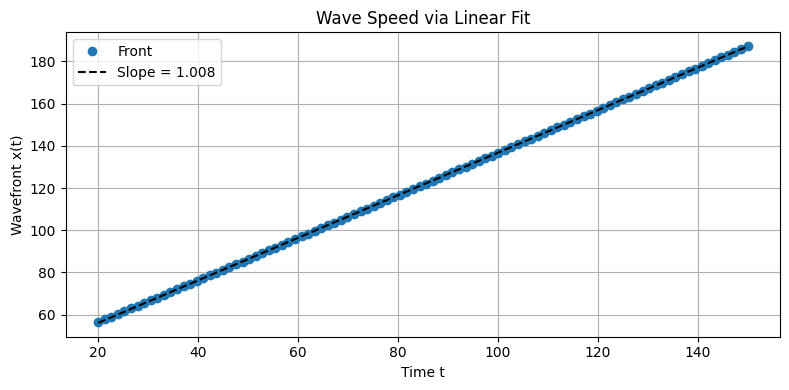

Estimated speed = 1.0077, R² = 1.0000


(np.float64(1.0077243278631838),
 np.float64(35.96020142190379),
 np.float64(0.9999920611054655))

In [54]:
model2 = Dissertation_Plain_1D(L=200, N=501, T=200, dt=0.1,
                              t_start=20, t_end=150, num_points=100)
model2.solve()
model2.estimate_wave_speed(plot=True)

In [267]:
import numpy as np
from scipy.sparse import eye, diags
from scipy.sparse.linalg import spsolve
from scipy.interpolate import CubicSpline, PchipInterpolator, Akima1DInterpolator, interp1d
from scipy.optimize import root_scalar
from scipy.stats import linregress
import matplotlib.pyplot as plt
from numba import njit

@njit
def f_numba(N, rho, K):
    return rho * N * (1 - N / K)

@njit
def g_numba(N, M, k):
    return -k * M * N

@njit
def build_laplacian_diagonals_avg(m, D, dx):
    N = len(m)
    lower = np.zeros(N)
    center = np.zeros(N)
    upper = np.zeros(N)

    for i in range(1, N - 1):
        ml = 0.5 * (m[i - 1] + m[i])
        mr = 0.5 * (m[i] + m[i + 1])
        Dl = max(1e-6, D * ml * (1 - ml))
        Dr = max(1e-6, D * mr * (1 - mr))
        lower[i] = Dl
        upper[i] = Dr
        center[i] = - (Dl + Dr)

    # Neumann BCs
    mr = 0.5 * (m[0] + m[1])
    Dr = max(1e-6, D * mr * (1 - mr))
    center[0] = -2 * Dr
    upper[0] = 2 * Dr

    ml = 0.5 * (m[-2] + m[-1])
    Dl = max(1e-6, D * ml * (1 - ml))
    center[-1] = -2 * Dl
    lower[-1] = 2 * Dl

    return (1.0 / dx**2) * lower, (1.0 / dx**2) * center, (1.0 / dx**2) * upper

class Dissertation_Plain_1D:
    def __init__(self, D=1.0, rho=1.0, K=1.0, k=1.0,
                 n0=1.0, m0=0.5, Mmax=1.0, perc=0.2,
                 L=1000.0, N=5001, T=1000.0, dt=0.1,
                 scheme="AB2AM2", init_type="step", steepness=0.1,
                 t_start=50.0, t_end=500.0, num_points=200):

        self.D = D; self.rho = rho; self.K = K
        self.k = k; self.n0 = n0; self.m0 = m0
        self.steepness = steepness
        self.Mmax = Mmax; self.perc = perc
        self.L = L; self.N = N; self.dx = L / (N - 1)
        self.x = np.linspace(0, L, N)
        self.T = T; self.dt = dt; self.Nt = int(T / dt)
        self.scheme = scheme.upper()
        self.init_type = init_type
        self.times = np.linspace(0, T, self.Nt)
        self.N_arr = np.zeros((self.Nt, self.N))
        self.M_arr = np.zeros((self.Nt, self.N))
        self.wave_speed = None

        # Wave speed tracking parameters
        self.t_start = t_start
        self.t_end = t_end
        self.num_points = num_points

    def initial_condition(self):
        if self.init_type == "step":
            N0 = self.n0 * np.where(self.x < self.perc * self.L, 0.7, 0.0)
        elif self.init_type == "tanh":
            N0 = self.n0 * 0.5 * (1 - np.tanh(self.steepness * (self.x - self.perc * self.L)))
        else:
            raise ValueError("Unknown initial condition type.")
        M0 = self.m0 * self.Mmax * np.ones_like(self.x)
        return N0, M0

    def update_laplacian(self, M):
        lower, center, upper = build_laplacian_diagonals_avg(M, self.D, self.dx)
        return diags([lower[1:], center, upper[:-1]], [-1, 0, 1], format="csr")

    def solve(self):
        N0, M0 = self.initial_condition()
        N_prev, M_prev = N0.copy(), M0.copy()
        f_prev = f_numba(N_prev, self.rho, self.K)
        g_prev = g_numba(N_prev, M_prev, self.k)
        L_prev = self.update_laplacian(M_prev)

        N_curr = spsolve(eye(self.N) - self.dt * L_prev, N_prev + self.dt * f_prev)
        M_curr = M_prev + self.dt * g_prev

        self.N_arr[0], self.M_arr[0] = N_prev, M_prev
        self.N_arr[1], self.M_arr[1] = N_curr, M_curr

        for i in range(2, self.Nt):
            L_curr = self.update_laplacian(M_curr)
            f_curr = f_numba(N_curr, self.rho, self.K)
            g_curr = g_numba(N_curr, M_curr, self.k)

            rhs = (eye(self.N) + 0.5 * self.dt * L_prev) @ N_curr + self.dt * (1.5 * f_curr - 0.5 * f_prev)
            A = (eye(self.N) - 0.5 * self.dt * L_curr)
            N_next = spsolve(A.tocsc(), rhs)
            N_next[0], N_next[-1] = N_next[1], N_next[-2]

            M_next = M_curr + self.dt * g_curr
            self.N_arr[i] = N_next
            self.M_arr[i] = M_next

            N_prev, N_curr = N_curr, N_next
            M_prev, M_curr = M_curr, M_next
            f_prev, g_prev = f_curr, g_curr
            L_prev = L_curr

    def track_wavefront_local_interpolation(self, threshold=0.5, band=(0.1, 0.9),
                                            spline_type='cubic', target='N'):
        x = self.x
        t_vec = self.times
        u_arr = self.N_arr if target.lower() == 'n' else self.M_arr
        t_list = np.linspace(self.t_start, self.t_end, self.num_points)
        x_fronts, t_fronts = [], []

        def get_spline(method, x, y):
            if method == 'cubic': return CubicSpline(x, y)
            if method == 'pchip': return PchipInterpolator(x, y)
            if method == 'akima': return Akima1DInterpolator(x, y)
            if method == 'linear': return interp1d(x, y, kind='linear', fill_value="extrapolate")
            raise ValueError(f"Unsupported spline_type: {method}")

        for t_target in t_list:
            idx = np.argmin(np.abs(t_vec - t_target))
            u = u_arr[idx]
            mask = (u > band[0]) & (u < band[1])
            if np.sum(mask) < 5:
                continue
            x_local, u_local = x[mask], u[mask]
            sort_idx = np.argsort(x_local)
            x_local, u_local = x_local[sort_idx], u_local[sort_idx]
            spline = get_spline(spline_type, x_local, u_local)
            crossing_idx = np.where(np.sign(u_local[:-1] - threshold) != np.sign(u_local[1:] - threshold))[0]
            if len(crossing_idx) == 0:
                continue
            i = crossing_idx[0]
            x_left, x_right = x_local[i], x_local[i + 1]
            try:
                sol = root_scalar(lambda x_val: spline(x_val) - threshold, bracket=[x_left, x_right])
                if sol.converged:
                    x_star = sol.root
                    x_fronts.append(x_star)
                    t_fronts.append(t_target)
            except:
                continue

        return np.array(t_fronts), np.array(x_fronts)

    def estimate_wave_speed(self, threshold=0.5, band=(0.1, 0.9), spline_type='cubic',
                            plot=True, target='N'):
        t_fronts, x_fronts = self.track_wavefront_local_interpolation(threshold, band, spline_type, target)
        if len(t_fronts) < 2:
            print("❌ Not enough valid front points.")
            return None, None, None

        slope, intercept, r_value, _, _ = linregress(t_fronts, x_fronts)

        if plot:
            plt.figure(figsize=(8, 4))
            plt.plot(t_fronts, x_fronts, 'o', label='Front')
            plt.plot(t_fronts, slope * t_fronts + intercept, 'k--', label=f'Slope = {slope:.3f}')
            plt.xlabel("Time t")
            plt.ylabel("Wavefront x(t)")
            plt.title("Wave Speed via Linear Fit")
            plt.legend(); plt.grid(True); plt.tight_layout()
            plt.show()

        print(f"Estimated speed = {slope:.4f}, R² = {r_value**2:.4f}")
        return slope, intercept, r_value**2

    def plot_u_m_with_custom_style(self, t_indices=[0, 500, 750, 1000],
                               arrow_len=None, arrow_lw=2.5,
                               arrow_shift_frac=0.01,    # right shift as fraction of L
                               bottom_y=0.2,             # y for blue arrow
                               anchor_x=None):           # set a fixed x for arrows (end tip)
        x, N_arr, M_arr, t_vec = self.x, self.N_arr, self.M_arr, self.times
    
        # Ensure wave speed is available (uses class's t_start/t_end/num_points)
        if getattr(self, "wave_speed", None) is None:
            self.wave_speed, _, _ = self.estimate_wave_speed(
                plot=False, target='N', threshold=0.5, band=(0.1, 0.9), spline_type='cubic'
            )
    
        # Arrow geometry
        if arrow_len is None:
            arrow_len = 0.15 * self.L             # 15% of domain -> nice & visible
        base_shift = arrow_shift_frac * self.L    # nudge to the right
    
        plt.figure(figsize=(8, 6))
    
        # Plot profiles
        for tidx in t_indices:
            t_label = int(t_vec[tidx])
            ls = '--' if t_label == 0 else '-'
            plt.plot(x, N_arr[tidx], color='red',  linestyle=ls, label=rf"$u(x,{t_label})$")
            plt.plot(x, M_arr[tidx], color='blue', linestyle=ls, label=rf"$m(x,{t_label})$")
    
        # --- Determine arrow x-positions ---
        if anchor_x is not None:
            # Force arrows to this x (as the tip), clip to domain
            arrow_x_end_m = np.clip(anchor_x, x[0], self.L)
            arrow_x_start_m = max(x[0], arrow_x_end_m - arrow_len)
        else:
            # Place blue arrow near ECM front found from the RIGHT
            m_last = M_arr[t_indices[-1]]
            mask_m = (m_last < 0.5)
            if np.any(mask_m):
                front_idx_m = len(x) - np.argmax(mask_m[::-1]) - 1
            else:
                front_idx_m = len(x) - 1
            arrow_x_end_m = min(self.L, x[front_idx_m] + base_shift)
            arrow_x_start_m = max(x[0], arrow_x_end_m - arrow_len)
    
        # Red arrow uses EXACTLY the same x-range (aligned above blue)
        arrow_x_end_u = arrow_x_end_m
        arrow_x_start_u = arrow_x_start_m
    
        # Draw arrows
        plt.annotate('', xy=(arrow_x_end_u, 0.9),      xytext=(arrow_x_start_u, 0.9),
                     arrowprops=dict(arrowstyle='->', color='red',  lw=arrow_lw))
        plt.annotate('', xy=(arrow_x_end_m, bottom_y), xytext=(arrow_x_start_m, bottom_y),
                     arrowprops=dict(arrowstyle='->', color='blue', lw=arrow_lw))
    
        # Left-side text
        x_text = x[0] + 0.02 * self.L
        plt.text(x_text, 0.92, rf"$\overline{{m}} = {self.m0}$", fontsize=18, ha='left')
        plt.text(x_text, 0.82, rf"$c = {self.wave_speed:.2f}$", fontsize=18, ha='left')
        

        # Formatting
        plt.xlabel(r"$x$", fontsize=18)
        plt.ylabel(r"$u(x,t),\, m(x,t)$", fontsize=18)
        plt.ylim([-0.05, 1.05])
        plt.yticks([0.0, 0.5, 1.0], fontsize=16)
        plt.xticks(fontsize=16)
        plt.title(rf"$\lambda = {self.k}$", fontsize=20)
        plt.xlim([0, self.L])
        plt.grid(False)
        plt.tight_layout()
        plt.show()
    
    def plot_u_m_with_custom_style(self, t_indices=[0, 500, 750, 1000],
                               arrow_len=None, arrow_lw=2.5,
                               arrow_shift_frac=0.01,       # right shift as fraction of L
                               bottom_y=0.2,                # y for blue arrow
                               arrow_start_frac=0.5,        # where arrow starts (as fraction of L)
                               head_length=6, head_width=3  # arrowhead size
                               ):
        x, N_arr, M_arr, t_vec = self.x, self.N_arr, self.M_arr, self.times
    
        # Ensure wave speed is available
        if getattr(self, "wave_speed", None) is None:
            self.wave_speed, _, _ = self.estimate_wave_speed(
                plot=False, target='N', threshold=0.5, band=(0.1, 0.9), spline_type='cubic'
            )
    
        # Arrow geometry
        if arrow_len is None:
            arrow_len = 0.15 * self.L  # default 15% of domain
        base_shift = arrow_shift_frac * self.L
    
        plt.figure(figsize=(8, 6))
    
        # Plot profiles
        for tidx in t_indices:
            t_label = int(t_vec[tidx])
            ls = '--' if t_label == 0 else '-'
            plt.plot(x, N_arr[tidx], color='red', linestyle=ls, label=rf"$u(x,{t_label})$")
            plt.plot(x, M_arr[tidx], color='blue', linestyle=ls, label=rf"$m(x,{t_label})$")
    
        # Force arrows to start from arrow_start_frac * L
        arrow_x_start_m = arrow_start_frac * self.L
        arrow_x_end_m = arrow_x_start_m + arrow_len
    
        arrow_x_start_u = arrow_x_start_m
        arrow_x_end_u = arrow_x_end_m
    
        # Arrow styles
        arrow_style_red = dict(arrowstyle=f'->,head_length={head_length},head_width={head_width}',
                               color='red', lw=arrow_lw)
        arrow_style_blue = dict(arrowstyle=f'->,head_length={head_length},head_width={head_width}',
                                color='blue', lw=arrow_lw)
    
        # Draw arrows
        plt.annotate('', xy=(arrow_x_end_u, 0.9), xytext=(arrow_x_start_u, 0.9),
                     arrowprops=arrow_style_red)
        plt.annotate('', xy=(arrow_x_end_m, bottom_y), xytext=(arrow_x_start_m, bottom_y),
                     arrowprops=arrow_style_blue)
    
        # Left-side text
        x_text = x[0] + 0.02 * self.L
        c_str = str(self.wave_speed)[:4]  # take first 4 chars, no rounding
        plt.text(x_text, 0.92, rf"$\overline{{m}} = {self.m0}$", fontsize=18, ha='left')
        plt.text(x_text, 0.82, rf"$c = {c_str}$", fontsize=18, ha='left')
    
        # Formatting
        plt.xlabel(r"$x$", fontsize=18)
        plt.ylabel(r"$u(x,t),\, m(x,t)$", fontsize=18)
        plt.ylim([-0.05, 1.05])
        plt.yticks([0.0, 0.5, 1.0], fontsize=16)
        plt.xticks(fontsize=16)
        plt.title(rf"$\lambda = {self.k}$", fontsize=20)
        plt.xlim([0, self.L])
        plt.grid(False)
        plt.tight_layout()
        plt.show()

    def plot_u_m_with_custom_style(self, t_indices=[0, 500, 750, 1000],
                               arrow_len=None, arrow_lw=2.5,
                               arrow_start_frac=0.5,        # start location as fraction of L
                               head_length=6, head_width=3, # arrowhead size
                               bottom_y=0.2):               # y for blue arrow

        x, N_arr, M_arr, t_vec = self.x, self.N_arr, self.M_arr, self.times
    
        # Ensure wave speed is available
        if getattr(self, "wave_speed", None) is None:
            self.wave_speed, _, _ = self.estimate_wave_speed(
                plot=False, target='N', threshold=0.5, band=(0.1, 0.9), spline_type='cubic'
            )
    
        # Arrow geometry
        if arrow_len is None:
            arrow_len = 0.15 * self.L  # default 15% of domain
    
        # Compute start/end, clamped to [0, L]
        arrow_x_start = np.clip(arrow_start_frac * self.L, 0.0, self.L)
        arrow_x_end   = np.clip(arrow_x_start + arrow_len, 0.0, self.L)
        # If clamping collapses the arrow, back off start a bit
        if arrow_x_end <= arrow_x_start:
            arrow_x_start = np.clip(self.L - arrow_len, 0.0, self.L)
            arrow_x_end   = self.L
    
        plt.figure(figsize=(8, 6))
    
        # Plot profiles (dashed for t=0)
        for tidx in t_indices:
            t_label = int(t_vec[tidx])
            ls = '--' if t_label == 0 else '-'
            plt.plot(x, N_arr[tidx], color='red',  linestyle=ls, label=rf"$u(x,{t_label})$")
            plt.plot(x, M_arr[tidx], color='blue', linestyle=ls, label=rf"$m(x,{t_label})$")
    
        # Arrow styles (slightly larger heads)
        arrow_style_red  = dict(arrowstyle=f'->,head_length={head_length},head_width={head_width}',
                                color='red',  lw=arrow_lw)
        arrow_style_blue = dict(arrowstyle=f'->,head_length={head_length},head_width={head_width}',
                                color='blue', lw=arrow_lw)
    
        # Draw arrows, aligned horizontally
        plt.annotate('', xy=(arrow_x_end, 0.9),     xytext=(arrow_x_start, 0.9),     arrowprops=arrow_style_red)
        plt.annotate('', xy=(arrow_x_end, bottom_y), xytext=(arrow_x_start, bottom_y), arrowprops=arrow_style_blue)
    
        # Left-side text (speed string: take first 4 chars without rounding)
        x_text = x[0] + 0.02 * self.L
        c_str = str(self.wave_speed)[:4] if self.wave_speed is not None else "—"
        plt.text(x_text, 0.92, rf"$\overline{{m}} = {self.m0}$", fontsize=18, ha='left')
        plt.text(x_text, 0.82, rf"$c = {c_str}$", fontsize=18, ha='left')
    
        # Formatting
        plt.xlabel(r"$x$", fontsize=18)
        plt.ylabel(r"$u(x,t),\, m(x,t)$", fontsize=18)
        plt.ylim([-0.05, 1.05])
        plt.yticks([0.0, 0.5, 1.0], fontsize=16)
        plt.xticks(fontsize=16)
        plt.title(rf"$\lambda = {self.k}$", fontsize=20)
        plt.xlim([0, self.L])
        plt.grid(False)
        plt.tight_layout()
        plt.show()
    

model4 = Dissertation_Plain_1D(
    L=200, N=1001, T=200, dt=0.1, k = 0.5,
    init_type="tanh", steepness=.85, perc=0.4,
    t_start=20, t_end=150, num_points=200
)
model4.solve()
model4.estimate_wave_speed(plot=True)

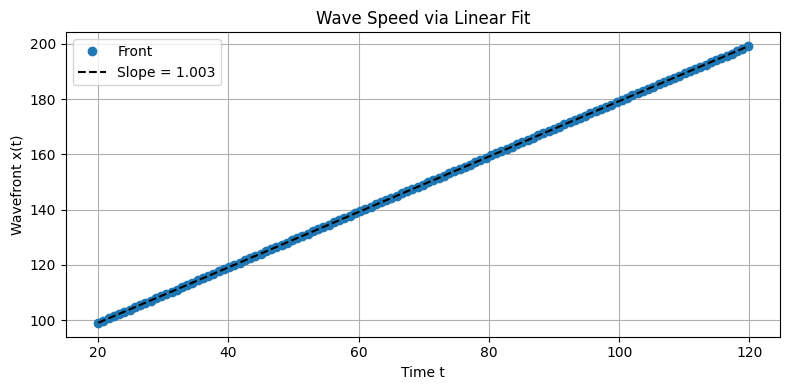

Estimated speed = 1.0035, R² = 1.0000


(np.float64(1.003454724758905),
 np.float64(78.99046212954997),
 np.float64(0.9999963712644521))

In [268]:
model4 = Dissertation_Plain_1D(
    L=200, N=5001, T=200, dt=0.1, k = 0.5,
    init_type="tanh", steepness=.85, perc=0.4,
    t_start=20, t_end=180, num_points=200
)
model4.solve()
model4.estimate_wave_speed(plot=True)

Estimated speed = 1.0035, R² = 1.0000


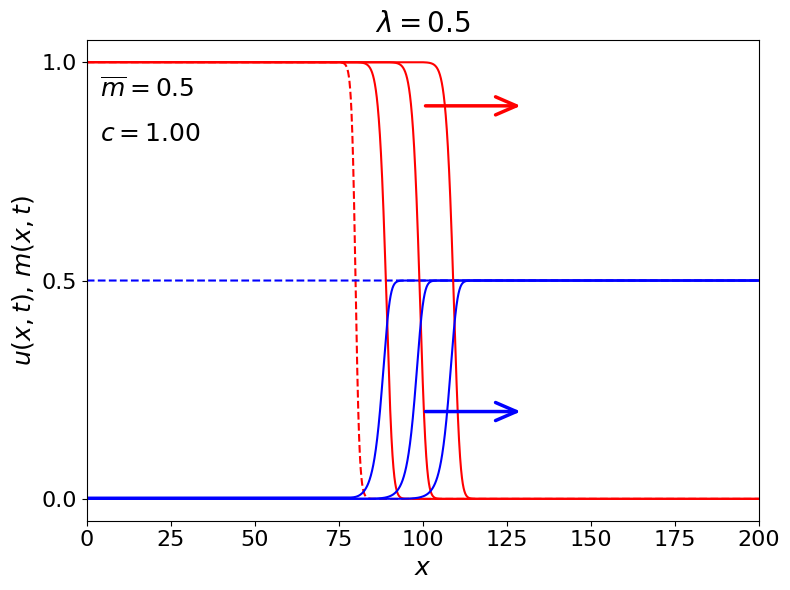

In [271]:
model4.plot_u_m_with_custom_style([0, 100,200, 300], head_length=1.5, head_width=.65)